# Machine learning to predict new crescent moon visibility

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING IMPORTS
#import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score 
from sklearn.model_selection import GridSearchCV

In [97]:
METHOD = True # replace seen column with method seen column
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
GRID_SEARCH = False # gridsearch for best random forest hyperparameters

In [98]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)

data = pd.concat([icouk_data,icop_data,alrefay_data])

print(f"Loaded {data.shape[0]} rows")

data = data.drop(["Index","q","W","q'","W'"], axis = 1)

if METHOD:
    data = data.drop('Seen', axis = 1) # replaced by method column
    ptype = [r"Not_seen", r"Seen_eye", r"Seen_binoculars", r"Seen_telescope", r"Seen_ccd"] # CHANGE THIS
else:
    data=data.drop('Method', axis = 1)
    # List of label options
    ptype = [r"Seen", r"Not_seen"]

if RANDOM:
    data.insert(1,"Random1",np.random.rand(data.shape[0],1))
    data.insert(2,"Random2",np.random.rand(data.shape[0],1))
    data = data[['Seen', "Random1","Random2"]]

if CLOUDCUT:
    data = data[data["Cloud Level"] <= 0.5]


data.head(10)

Loaded 3260 rows


,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Parallax,Cloud Level,Method
0,2457309.222,53.95763,-1.08271,0.722,2457309.213,2457309.232,27.05935,1.51838,252.00232,-1.73173,259.02584,0.00271,0.99508,7.73820,3.25011,7.02353,54.14174,1.0,Not_seen
1,2457339.187,53.95763,-1.08271,1.687,2457339.170,2457339.210,57.80819,3.36486,235.23797,-3.31808,243.97528,0.00266,0.98725,10.99616,6.68294,8.73731,55.04632,0.5,Not_seen
2,2457398.185,53.95763,-1.08271,0.685,2457398.165,2457398.211,67.20869,3.82122,233.19221,-3.52379,236.46999,0.00252,0.98095,8.04228,7.34501,3.27778,58.03155,0.5,Not_seen
3,2457428.238,53.58333,-2.43333,1.738,2457428.209,2457428.275,94.68585,6.40548,245.47535,-5.81151,253.06492,0.00244,0.98427,14.37485,12.21699,7.58956,59.59324,1.0,Not_seen
4,2457428.236,52.63860,-1.13169,1.736,2457428.207,2457428.272,93.09817,6.46498,246.07108,-5.86126,253.40983,0.00244,0.98427,14.33820,12.32624,7.33875,59.58563,0.0,Seen_eye
5,2457457.261,52.63860,-1.13169,0.761,2457457.245,2457457.281,51.24933,3.50315,262.44978,-3.43885,267.72094,0.00240,0.99075,8.71450,6.94200,5.27116,60.83454,1.0,Not_seen
6,2457457.259,51.87967,-0.41748,0.759,2457457.244,2457457.279,50.69011,3.53057,262.58959,-3.46038,267.74070,0.00240,0.99075,8.68183,6.99094,5.15110,60.83247,0.5,Not_seen
7,2457457.259,51.39822,-0.19837,0.759,2457457.243,2457457.278,50.38849,3.55198,262.67600,-3.47683,267.75591,0.00240,0.99075,8.67048,7.02881,5.07991,60.83099,1.0,Not_seen
8,2457457.260,53.95763,-1.08271,0.760,2457457.244,2457457.280,51.96781,3.43075,262.20043,-3.37986,267.64850,0.00240,0.99075,8.71957,6.81061,5.44807,60.83909,1.0,Not_seen
9,2457487.316,53.58333,-2.43333,1.816,2457487.287,2457487.353,95.45765,6.69411,277.61713,-6.00369,291.47930,0.00240,0.99931,18.77762,12.69780,13.86218,60.77741,1.0,Not_seen


In [99]:
# Visualising a couple of variables.
variable_list =  data.columns.tolist()
#print(variable_list)

# Plot data
showpairplot = False
if showpairplot == True:
   fig = sns.pairplot(data[variable_list], hue = 'Seen', palette = 'bright')

   # Change location of legend
   fig._legend.set_bbox_to_anchor((1.05, 0.5))

   # Add legend
   for t, l in zip(fig._legend.texts, ptype):
      t.set_text(str(t.get_text()) + " - " + str(l))

   plt.show()


In [100]:
# List of features without label feature
features = variable_list
#features.remove('Seen')
#print(features)


if METHOD:
    y = np.array(data['Method'])
    features.remove('Method')
    pos = 'Seen_eye' # for ROC curve +ve result
else:
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

In [101]:
# Produce randomforest classifier model and fit to training data
# Keep the random_state=1 in your arguments
# gini or entropy
rf = RandomForestClassifier(n_estimators=100)#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)

# Fitting takes the input and "truth" data for classification purposes
rf.fit(x_train, y_train)

In [ ]:
# Produce predictions for the classification of your training dataset using your model:
y_pred = rf.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",metrics.accuracy_score(y_train, y_pred))
rf_acc_train = metrics.accuracy_score(y_train, y_pred)
y_pred = rf.predict(x_test)
print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred))
rf_acc_test = metrics.accuracy_score(y_test, y_pred)

Accuracy on training dataset: 0.9934815950920245
Accuracy on testing dataset: 0.8144171779141104


ROC curve

In [ ]:
#y_train2 = y_train.copy()
#y_test2 = y_test.copy()

#y_train2[y_train2 == 'Seen'] = 1
#y_train2[y_train2 == 'Not_seen'] = 0

#y_test2[y_test2 == 'Seen'] = 1
#y_test2[y_test2 == 'Not_seen'] = 0

#print(y_train2)

In [ ]:
# Get predicted class probabilities for the test set 
y_pred_prob = rf.predict_proba(x_test)#[:, 1] 

#y_pred_prob[y_pred_prob == 'Seen'] = 1
#y_pred_prob[y_pred_prob == 'Not_seen'] = 0

# Compute the false positive rate (FPR) 
# and true positive rate (TPR) for different classification thresholds 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=pos)

# Compute the ROC AUC score 

if METHOD:
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
else:
    roc_auc = roc_auc_score(y_test, y_pred_prob)

roc_auc

AxisError: axis 1 is out of bounds for array of dimension 1

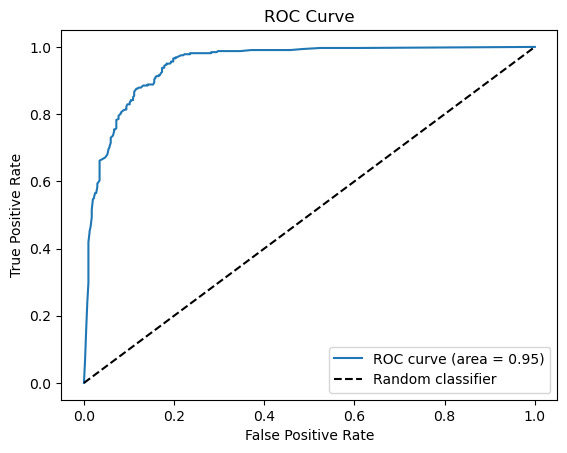

In [ ]:

# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

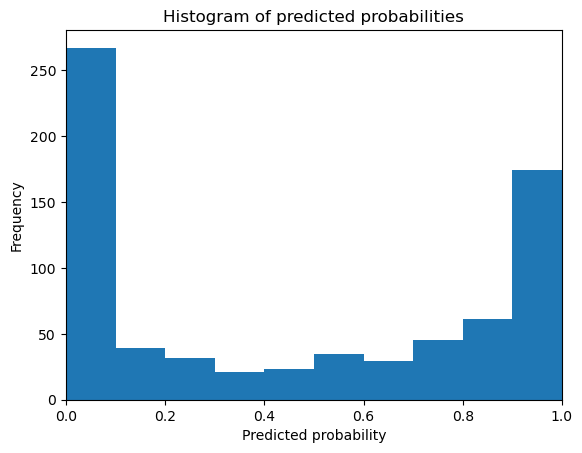

In [ ]:
# Plot the predicted class probabilities 
plt.hist(y_pred_prob, bins=10) 
plt.xlim(0, 1) 
plt.title('Histogram of predicted probabilities') 
plt.xlabel('Predicted probability') 
plt.ylabel('Frequency') 
plt.show() 


In [ ]:
# Function to run thr random forest several times to get an average
def random_forest(x_train, y_train, x_test, y_test, rf):
    accuracy_arr = []
    for i in range(20):
        # Fitting takes the input and "truth" data for classification purposes
        rf.fit(x_train, y_train)
        # Produce predictions for the classification of your training dataset using your model:
        y_pred = rf.predict(x_test)
        #print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred))
        accuracy_arr.append(metrics.accuracy_score(y_test, y_pred))
    
    accuracy_avg = np.mean(accuracy_arr)
    accuracy_std = np.std(accuracy_arr)
    return accuracy_avg,accuracy_std

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini')#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
accuracy_val=random_forest(x_train, y_train, x_test, y_test, rf)

print(r"When run 20 times the accuracy is {:.5} \pm {:.5}:".format(accuracy_val[0],accuracy_val[1]))

When run 20 times the accuracy is 0.87293 \pm 0.0044179:


In [ ]:
print('Oob Score: ', rf.score(x_test, y_test))

Oob Score:  0.8760330578512396


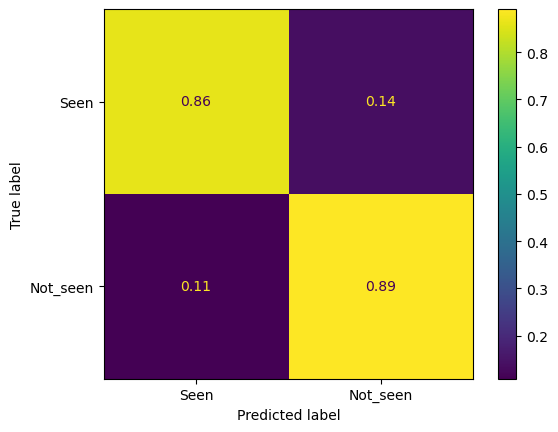

In [ ]:
# plot your confusion matrix
cm = confusion_matrix(y_test, y_pred ,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
disp.plot()
plt.show()

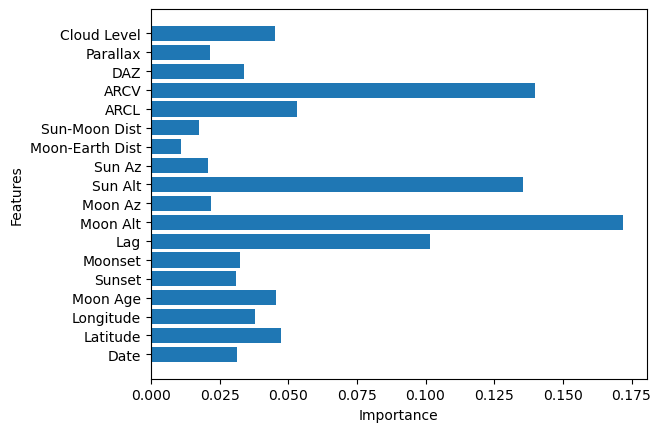

In [ ]:
# Plot importance
importance = rf.feature_importances_
ytix = features

plt.barh(range(len(features)), importance)
plt.yticks(range(len(features)), features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Hyperparameter adjustment - not of much note yet

In [ ]:
if GRID_SEARCH:
    rf = RandomForestClassifier(random_state=42)

    params = {
        'max_depth': [2,3,5,10,20],
        'min_samples_leaf': [5,10,20,50,100,200],
        'n_estimators': [10,25,30,50,100,200]
    }

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf,
        param_grid=params,
        cv = 4,
         verbose=1, scoring="accuracy")

    grid_search.fit(x_train, y_train)
    grid_search.best_score_
    rf_best = grid_search.best_estimator_
    rf_best

    # Produce predictions for the classification of your training dataset using your model:
    y_pred_best = rf_best.predict(x_train)

    # plot the accuracies of said predictions
    print("Accuracy on training dataset:",metrics.accuracy_score(y_train, y_pred_best))
    rf_best_acc_train = metrics.accuracy_score(y_train, y_pred_best)
    y_pred_best = rf_best.predict(x_test)
    print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred_best))
    rf_best_acc_train = metrics.accuracy_score(y_test, y_pred_best)

In [ ]:
rf_best

NameError: name 'rf_best' is not defined

In [ ]:
#rf_best = grid_search.best_estimator_
#rf_best

In [ ]:
# Produce predictions for the classification of your training dataset using your model:
#y_pred_best = rf_best.predict(x_train)

# plot the accuracies of said predictions
#print("Accuracy on training dataset:",metrics.accuracy_score(y_train, y_pred_best))
#rf_best_acc_train = metrics.accuracy_score(y_train, y_pred_best)
#y_pred_best = rf_best.predict(x_test)
#print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred_best))
#rf_best_acc_train = metrics.accuracy_score(y_test, y_pred_best)